# Expériences/Tests

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from base import *
from mltools import *

## Régression linéaire

In [2]:
datax, datay = gen_arti(data_type=0, epsilon=0.1)

In [3]:
# Initialize model
linear = Linear(datax.shape[-1], datay.shape[-1])
mse_loss = MSELoss()

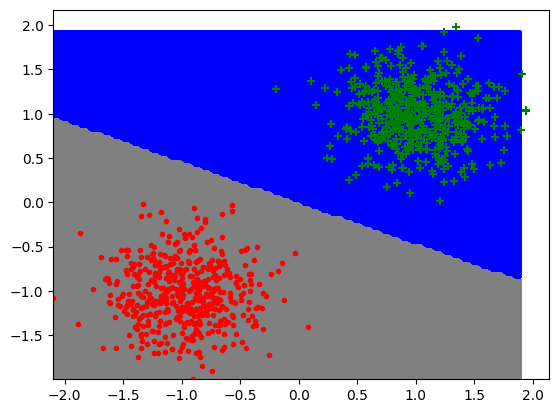

In [4]:
# Avant apprentissage
w = linear._parameters["weights"]
plot_frontiere(datax,lambda x : np.sign(x.dot(w)),step=100)
plot_data(datax, datay)

In [5]:
# Parameters
n_iterations = 300
gradient_step = 0.0001

In [6]:
# Descent gradient
loss_history = np.zeros(n_iterations)

for i in range(n_iterations):
    # Forward pass
    yhat = linear.forward(datax)
    loss = mse_loss.forward(datay, yhat)
    loss_history[i] = loss.mean()
    
    # Backward pass
    delta = mse_loss.backward(datay, yhat)
    
    linear.zero_grad()
    linear.backward_update_gradient(datax, delta)
    linear.update_parameters(gradient_step)

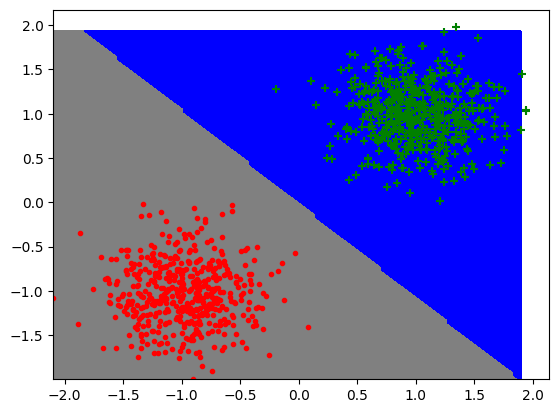

In [7]:
# Après apprentissage
w = linear._parameters["weights"]
plot_frontiere(datax,lambda x : np.sign(x.dot(w)),step=100)
plot_data(datax, datay)

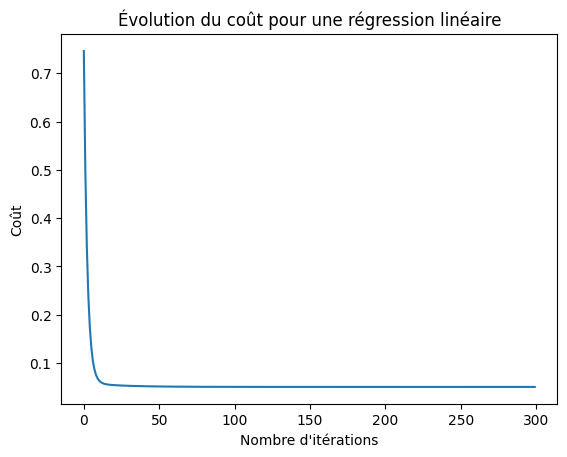

In [8]:
plt.plot(range(n_iterations), loss_history)
plt.xlabel("Nombre d'itérations")
plt.ylabel("Coût")
plt.title("Évolution du coût pour une régression linéaire")
plt.show()

## Réseau à 2 couches avec tanh entre les 2 couches et sigmoide à la sortie

In [9]:
datax, datay = gen_arti(nbex=10000, data_type=1)

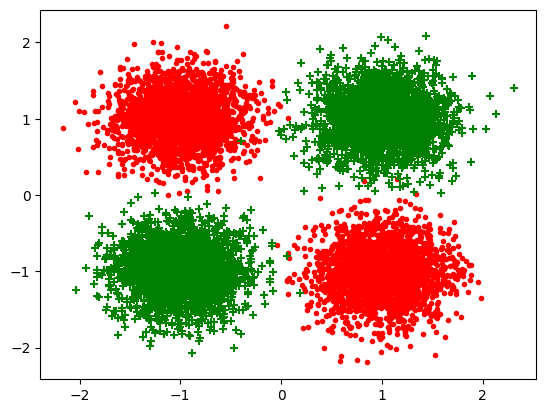

In [10]:
plot_data(datax, datay)

In [11]:
# Initialize the layers
hidden_dim = 16

layer1 = Linear(datax.shape[-1], hidden_dim)
tanh = TanH()
layer2 = Linear(hidden_dim, datay.shape[-1])
sigmoid = Sigmoide()
loss_fn = MSELoss()

In [12]:
# Training parameters
num_epochs = 300
learning_rate = 0.0001

In [13]:
loss_history = np.zeros(num_epochs)
accuracy_history = np.zeros(num_epochs)

for epoch in range(num_epochs):
    # Forward pass
    output1 = layer1.forward(datax)
    output2 = tanh.forward(output1)
    output3 = layer2.forward(output2)
    yhat = sigmoid.forward(output3)
    loss = loss_fn.forward(datay, yhat)

    # Backward pass
    delta3 = loss_fn.backward(datay, yhat)
    delta2 = sigmoid.backward_delta(output3, delta3)
    delta1 = layer2.backward_delta(output2, delta2)
    layer2.backward_update_gradient(output2, delta2)
    delta0 = tanh.backward_delta(output1, delta1)
    layer1.backward_update_gradient(datax, delta0)

    # Update parameters
    layer1.update_parameters(learning_rate)
    layer2.update_parameters(learning_rate)

    loss_history[epoch] = loss.mean()
    accuracy_history[epoch] = accuracy_bin(yhat, datay)

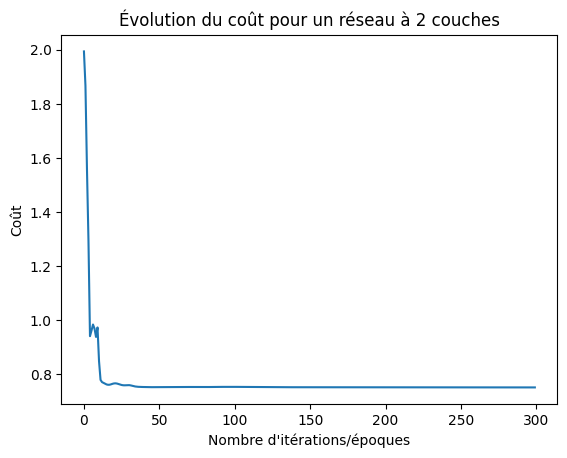

In [14]:
plt.plot(range(num_epochs), loss_history)
plt.xlabel("Nombre d'itérations/époques")
plt.ylabel("Coût")
plt.title("Évolution du coût pour un réseau à 2 couches")
plt.show()

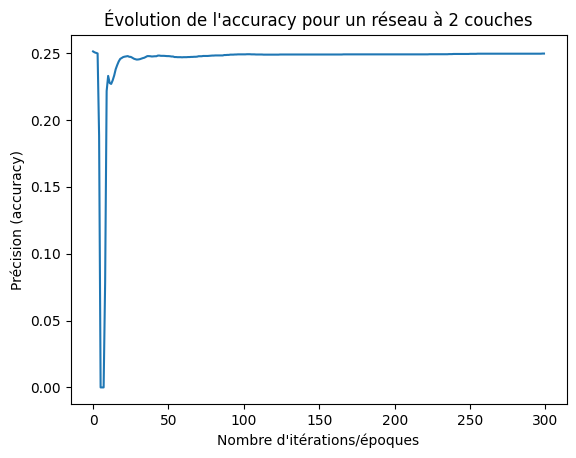

In [15]:
plt.plot(range(num_epochs), accuracy_history)
plt.xlabel("Nombre d'itérations/époques")
plt.ylabel("Précision (accuracy)")
plt.title("Évolution de l'accuracy pour un réseau à 2 couches")
plt.show()

## Utilisation des classes Sequentiel, Optim, et de la fonction SGD

In [16]:
datax, datay = gen_arti(nbex=10000, data_type=1)

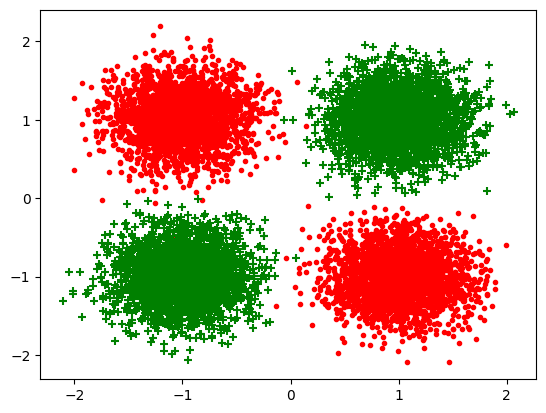

In [17]:
plot_data(datax, datay)

In [18]:
# Initialize the network
hidden_dim = 16

net = Sequentiel()
net.add_module(Linear(datax.shape[-1], hidden_dim))
net.add_module(TanH())
net.add_module(Linear(hidden_dim, datay.shape[-1]))
net.add_module(Sigmoide())

loss_fn = MSELoss()

In [19]:
# Training parameters
num_epochs = 300
learning_rate = 0.0001
batch_size = 25

In [20]:
opt = Optim(net, loss_fn, learning_rate)

In [21]:
loss_history = []
accuracy_history = []
for epoch in range(num_epochs):
    loss, acc = opt.step(datax, datay)
    loss_history.append(loss)
    accuracy_history.append(acc)

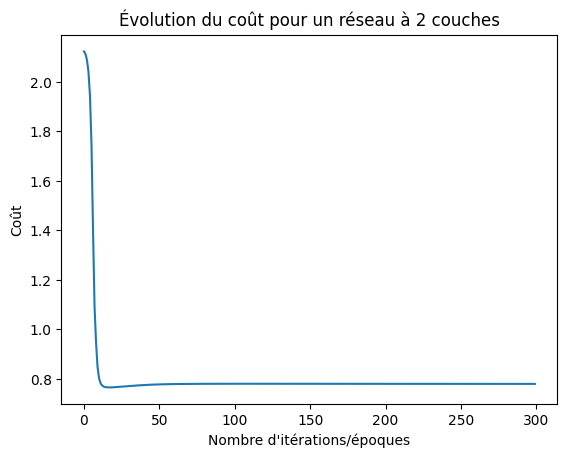

In [22]:
plt.plot(range(num_epochs), loss_history)
plt.xlabel("Nombre d'itérations/époques")
plt.ylabel("Coût")
plt.title("Évolution du coût pour un réseau à 2 couches")
plt.show()

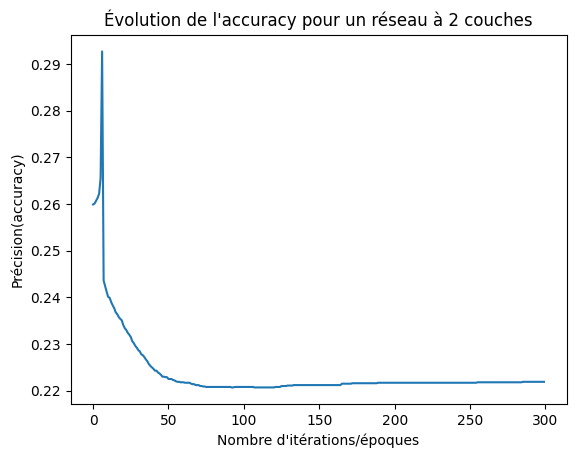

In [23]:
plt.plot(range(num_epochs), accuracy_history)
plt.xlabel("Nombre d'itérations/époques")
plt.ylabel("Précision(accuracy)")
plt.title("Évolution de l'accuracy pour un réseau à 2 couches")
plt.show()

## Test multi-classe sur le jeu de données des chiffres manuscrits

In [24]:
import pickle as pkl

In [25]:
data = pkl.load(open("usps.pkl",'rb'))
# data est un dictionnaire contenant les champs explicites X_train, X_test, Y_train, Y_test
X_train = np.array(data["X_train"],dtype=float) # changement de type pour éviter les problèmes d'affichage
X_test = np.array(data["X_test"],dtype=float)
Y_train = data["Y_train"]
Y_test = data["Y_test"]

In [26]:
# One-hot encoding 
num_classes = len(np.unique(Y_train))
Y_train = one_hot_encode(Y_train, num_classes)
Y_test = one_hot_encode(Y_test, num_classes)

In [27]:
# Initialize the network
hidden_dim1 = 128
hidden_dim2 = 64

net = Sequentiel()
net.add_module(Linear(X_train.shape[-1], hidden_dim1))
net.add_module(TanH())
net.add_module(Linear(hidden_dim1, hidden_dim2))
net.add_module(TanH())
net.add_module(Linear(hidden_dim2, Y_train.shape[-1]))

loss_fn = CELogSoftmax()

In [28]:
# Training parameters
num_epochs = 300
learning_rate = 0.0001

In [29]:
opt = Optim(net, loss_fn, learning_rate)

In [30]:
loss_history = []
accuracy_history = []
for i in range(num_epochs):
    loss, acc = opt.step(X_train, Y_train)
    loss_history.append(np.mean(loss))
    accuracy_history.append(acc)

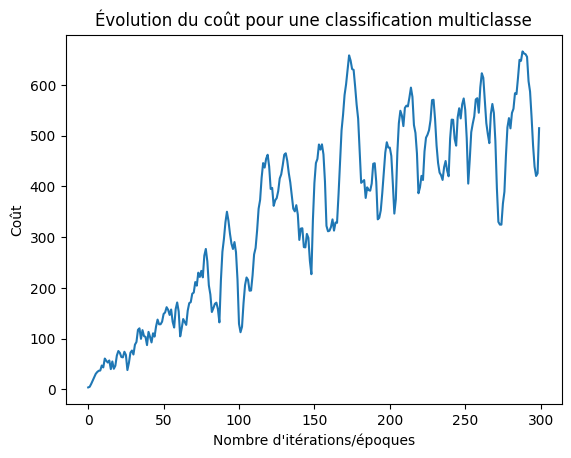

In [31]:
plt.plot(range(num_epochs), loss_history)
plt.xlabel("Nombre d'itérations/époques")
plt.ylabel("Coût")
plt.title("Évolution du coût pour une classification multiclasse")
plt.show()

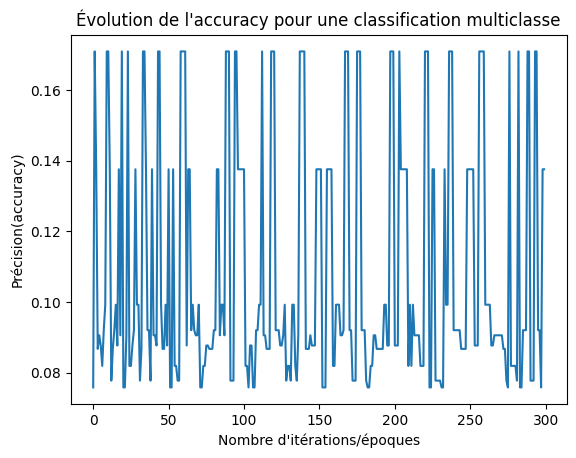

In [32]:
plt.plot(range(num_epochs), accuracy_history)
plt.xlabel("Nombre d'itérations/époques")
plt.ylabel("Précision(accuracy)")
plt.title("Évolution de l'accuracy pour une classification multiclasse")
plt.show()